# Loop 3 Analysis: Understanding the Gap to Target

**Current Best**: 70.676059
**Target**: 68.892266
**Gap**: 1.78 points (2.59%)

The evaluator correctly identified that local optimization cannot close this gap. We need to:
1. Analyze which N values have the most room for improvement
2. Extract lattice parameters from best solutions
3. Try fundamentally different approaches

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import affinity

# Tree shape
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

# Tree area
tree_poly = Polygon(zip(TX, TY))
TREE_AREA = tree_poly.area
print(f"Tree area: {TREE_AREA:.6f}")

# Load baseline from snapshots
baseline = pd.read_csv('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa-2025.csv')
print(f"Baseline shape: {baseline.shape}")
baseline.head()

Tree area: 0.245625
Baseline shape: (20100, 4)


,id,x,y,deg
0,001_0,s-48.196086194214246,s58.770984615214225,s45.0
1,002_0,s0.154097069621355887,s-0.038540742694794648,s203.629377730656841550
2,002_1,s-0.154097069621372845,s-0.561459257305224058,s23.629377730656791812
3,003_0,s1.123655816140301,s0.781101815992563,s111.125132292893
4,003_1,s1.23405569584216,s1.275999500663759,s66.370622269343


In [4]:
# Calculate score per N and packing efficiency
def get_side_length(df, n):
    """Get side length for N trees"""
    group = df[df['id'].str.startswith(f'{n:03d}_')].copy()
    group['xf'] = group['x'].astype(str).str.replace('s', '').astype(float)
    group['yf'] = group['y'].astype(str).str.replace('s', '').astype(float)
    group['degf'] = group['deg'].astype(str).str.replace('s', '').astype(float)
    
    # Get all polygon vertices
    all_x, all_y = [], []
    for _, row in group.iterrows():
        poly = Polygon(zip(TX, TY))
        poly = affinity.rotate(poly, row['degf'], origin=(0, 0))
        poly = affinity.translate(poly, row['xf'], row['yf'])
        xs, ys = poly.exterior.xy
        all_x.extend(xs)
        all_y.extend(ys)
    
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    return side

# Calculate for all N
results = []
for n in range(1, 201):
    side = get_side_length(baseline, n)
    score = side**2 / n
    efficiency = (n * TREE_AREA) / (side**2) * 100
    theoretical_min_side = np.sqrt(n * TREE_AREA)  # Perfect packing
    theoretical_min_score = TREE_AREA  # Perfect packing score per N
    gap_to_theoretical = score - theoretical_min_score
    
    results.append({
        'n': n,
        'side': side,
        'score': score,
        'efficiency': efficiency,
        'theoretical_min_side': theoretical_min_side,
        'theoretical_min_score': theoretical_min_score,
        'gap_to_theoretical': gap_to_theoretical
    })

results_df = pd.DataFrame(results)
print(f"Total score: {results_df['score'].sum():.6f}")
print(f"Theoretical minimum: {results_df['theoretical_min_score'].sum():.6f}")
print(f"\nScore breakdown:")
print(f"  N=1-10: {results_df[results_df['n'] <= 10]['score'].sum():.4f}")
print(f"  N=11-50: {results_df[(results_df['n'] > 10) & (results_df['n'] <= 50)]['score'].sum():.4f}")
print(f"  N=51-100: {results_df[(results_df['n'] > 50) & (results_df['n'] <= 100)]['score'].sum():.4f}")
print(f"  N=101-200: {results_df[results_df['n'] > 100]['score'].sum():.4f}")

Total score: 70.676102
Theoretical minimum: 49.125000

Score breakdown:
  N=1-10: 4.3291
  N=11-50: 14.7130
  N=51-100: 17.6411
  N=101-200: 33.9928


In [5]:
# Find N values with worst efficiency (most room for improvement)
results_df_sorted = results_df.sort_values('efficiency')
print("N values with WORST efficiency (most room for improvement):")
print(results_df_sorted[['n', 'side', 'score', 'efficiency', 'gap_to_theoretical']].head(20).to_string())

print("\nN values with BEST efficiency:")
print(results_df_sorted[['n', 'side', 'score', 'efficiency', 'gap_to_theoretical']].tail(10).to_string())

N values with WORST efficiency (most room for improvement):
     n      side     score  efficiency  gap_to_theoretical
0    1  0.813173  0.661250   37.145558            0.415625
1    2  0.949504  0.450779   54.488985            0.205154
2    3  1.142031  0.434745   56.498619            0.189120
4    5  1.443692  0.416850   58.924131            0.171225
3    4  1.290806  0.416545   58.967240            0.170920
6    7  1.673104  0.399897   61.422135            0.154272
5    6  1.548438  0.399610   61.466135            0.153985
8    9  1.867280  0.387415   63.400999            0.141790
7    8  1.755921  0.385407   63.731287            0.139782
14  15  2.384962  0.379203   64.774038            0.133578
9   10  1.940696  0.376630   65.216518            0.131005
20  21  2.811667  0.376451   65.247553            0.130826
19  20  2.742469  0.376057   65.315921            0.130432
10  11  2.033002  0.375736   65.371685            0.130111
21  22  2.873270  0.375258   65.454945            0.129

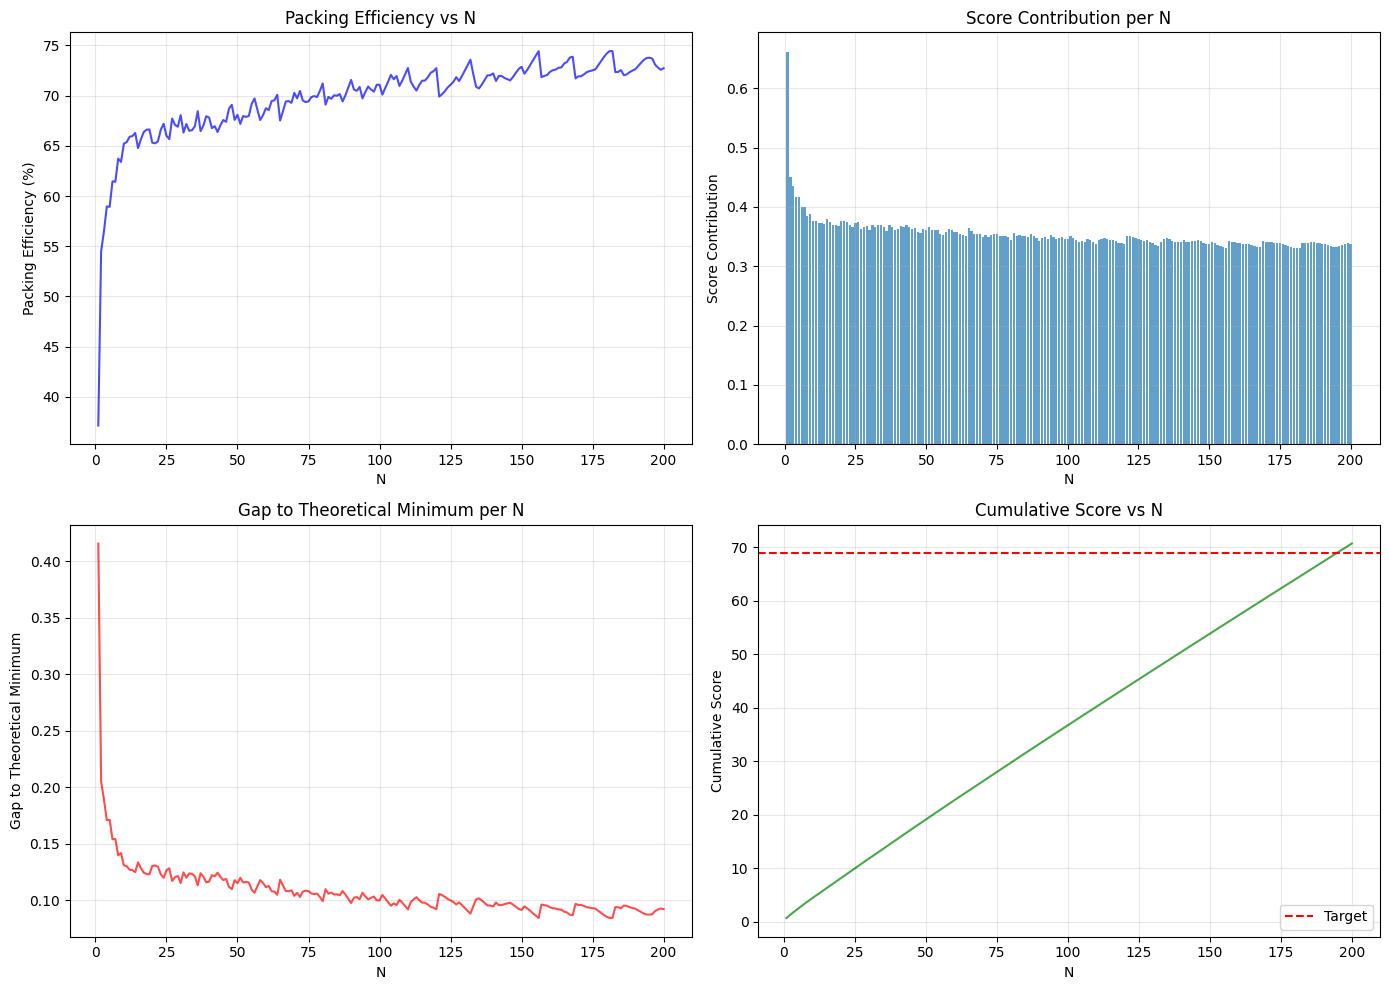

In [6]:
# Plot efficiency vs N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Efficiency vs N
ax1 = axes[0, 0]
ax1.plot(results_df['n'], results_df['efficiency'], 'b-', alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Packing Efficiency (%)')
ax1.set_title('Packing Efficiency vs N')
ax1.grid(True, alpha=0.3)

# Score contribution vs N
ax2 = axes[0, 1]
ax2.bar(results_df['n'], results_df['score'], alpha=0.7)
ax2.set_xlabel('N')
ax2.set_ylabel('Score Contribution')
ax2.set_title('Score Contribution per N')
ax2.grid(True, alpha=0.3)

# Gap to theoretical vs N
ax3 = axes[1, 0]
ax3.plot(results_df['n'], results_df['gap_to_theoretical'], 'r-', alpha=0.7)
ax3.set_xlabel('N')
ax3.set_ylabel('Gap to Theoretical Minimum')
ax3.set_title('Gap to Theoretical Minimum per N')
ax3.grid(True, alpha=0.3)

# Cumulative score
ax4 = axes[1, 1]
ax4.plot(results_df['n'], results_df['score'].cumsum(), 'g-', alpha=0.7)
ax4.axhline(y=68.892266, color='r', linestyle='--', label='Target')
ax4.set_xlabel('N')
ax4.set_ylabel('Cumulative Score')
ax4.set_title('Cumulative Score vs N')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/efficiency_analysis.png', dpi=100)
plt.show()

In [7]:
# Calculate how much improvement is needed per N to reach target
target_score = 68.892266
current_score = results_df['score'].sum()
gap = current_score - target_score

print(f"Current score: {current_score:.6f}")
print(f"Target score: {target_score:.6f}")
print(f"Gap to close: {gap:.6f}")

# If we improve efficiency uniformly, what efficiency do we need?
# Total score = sum(side^2/n) = sum(n*TREE_AREA/efficiency/n) = sum(TREE_AREA/efficiency)
# For uniform efficiency e: Total = 200 * TREE_AREA / e
# So e = 200 * TREE_AREA / Total
required_avg_efficiency = 200 * TREE_AREA / target_score * 100
current_avg_efficiency = 200 * TREE_AREA / current_score * 100

print(f"\nCurrent average efficiency: {current_avg_efficiency:.2f}%")
print(f"Required average efficiency: {required_avg_efficiency:.2f}%")
print(f"Efficiency improvement needed: {required_avg_efficiency - current_avg_efficiency:.2f}%")

Current score: 70.676102
Target score: 68.892266
Gap to close: 1.783836

Current average efficiency: 69.51%
Required average efficiency: 71.31%
Efficiency improvement needed: 1.80%


In [8]:
# Analyze lattice patterns in best solutions (from jazivxt kernel)
def generate_geometry_report(df):
    """Extract lattice parameters from best solutions"""
    df = df.copy()
    df['xf'] = df['x'].astype(str).str.replace('s', '').astype(float)
    df['yf'] = df['y'].astype(str).str.replace('s', '').astype(float)
    df['degf'] = df['deg'].astype(str).str.replace('s', '').astype(float) % 360
    df['is_blue'] = ~((df['degf'] > 90) & (df['degf'] <= 270))
    df['n_val'] = df['id'].apply(lambda x: int(str(x).split('_')[0]))
    
    # Find the top 20 best groups by efficiency
    scores = []
    for n in df['n_val'].unique():
        g = df[df['n_val'] == n]
        side = max(g['xf'].max() - g['xf'].min(), g['yf'].max() - g['yf'].min())
        scores.append({'n': n, 'score': (side**2)/n})
    
    top_ns = pd.DataFrame(scores).sort_values('score').head(20)['n'].values
    master_data = df[df['n_val'].isin(top_ns)]
    
    # Find relationship between Blue and nearest Pink neighbors
    blue = master_data[master_data['is_blue']]
    pink = master_data[~master_data['is_blue']]
    
    results = []
    for _, b in blue.iterrows():
        group_p = pink[pink['n_val'] == b['n_val']]
        if group_p.empty:
            continue
        
        dists = np.sqrt((group_p['xf'] - b['xf'])**2 + (group_p['yf'] - b['yf'])**2)
        idx = dists.idxmin()
        p_match = group_p.loc[idx]
        
        results.append({
            'dx': round(p_match['xf'] - b['xf'], 2),
            'dy': round(p_match['yf'] - b['yf'], 2),
            'blue_deg': round(b['degf'], 1),
            'pink_deg': round(p_match['degf'], 1)
        })
    
    report = pd.DataFrame(results).value_counts().reset_index(name='frequency')
    return report.head(10)

report = generate_geometry_report(baseline)
print("TOP 10 LATTICE OFFSETS & ANGLES:")
print(report)

TOP 10 LATTICE OFFSETS & ANGLES:
     dx    dy  blue_deg  pink_deg  frequency
0  0.25  0.04      63.4     243.4          2
1  0.24  0.06      67.9     247.9          2
2  0.24  0.06      66.9     246.9          2
3 -0.01  0.86     336.4     156.4          2
4  0.33 -0.06      27.1     206.6          1
5  0.31  0.52      23.6     203.6          1
6  0.30 -0.07      30.7     222.3          1
7  0.28  0.03      55.6     246.2          1
8  0.26 -0.44     293.4     152.4          1
9  0.17  0.40      69.3     262.8          1


In [9]:
# Identify which N values contribute most to the gap
# If we could achieve theoretical minimum for each N, what would the improvement be?
results_df['potential_improvement'] = results_df['gap_to_theoretical']
results_df_by_improvement = results_df.sort_values('potential_improvement', ascending=False)

print("N values with HIGHEST potential improvement (if we could achieve theoretical minimum):")
print(results_df_by_improvement[['n', 'score', 'theoretical_min_score', 'potential_improvement', 'efficiency']].head(20).to_string())

# Calculate cumulative potential improvement
results_df_by_improvement['cumulative_improvement'] = results_df_by_improvement['potential_improvement'].cumsum()
print(f"\nTotal potential improvement: {results_df['potential_improvement'].sum():.4f}")
print(f"Gap to target: {gap:.4f}")
print(f"\nWe need to capture {gap / results_df['potential_improvement'].sum() * 100:.1f}% of theoretical improvement potential")

N values with HIGHEST potential improvement (if we could achieve theoretical minimum):
     n     score  theoretical_min_score  potential_improvement  efficiency
0    1  0.661250               0.245625               0.415625   37.145558
1    2  0.450779               0.245625               0.205154   54.488985
2    3  0.434745               0.245625               0.189120   56.498619
4    5  0.416850               0.245625               0.171225   58.924131
3    4  0.416545               0.245625               0.170920   58.967240
6    7  0.399897               0.245625               0.154272   61.422135
5    6  0.399610               0.245625               0.153985   61.466135
8    9  0.387415               0.245625               0.141790   63.400999
7    8  0.385407               0.245625               0.139782   63.731287
14  15  0.379203               0.245625               0.133578   64.774038
9   10  0.376630               0.245625               0.131005   65.216518
20  21  0.376

In [10]:
# Summary of key findings
print("="*60)
print("KEY FINDINGS FOR STRATEGY")
print("="*60)

print(f"\n1. CURRENT STATE:")
print(f"   - Current score: {current_score:.6f}")
print(f"   - Target score: {target_score:.6f}")
print(f"   - Gap: {gap:.6f} ({gap/target_score*100:.2f}%)")

print(f"\n2. EFFICIENCY ANALYSIS:")
print(f"   - Current avg efficiency: {current_avg_efficiency:.2f}%")
print(f"   - Required avg efficiency: {required_avg_efficiency:.2f}%")
print(f"   - Worst efficiency N values: {results_df_sorted['n'].head(5).tolist()}")

print(f"\n3. HIGH-LEVERAGE N VALUES (worst efficiency):")
for _, row in results_df_sorted.head(10).iterrows():
    print(f"   N={int(row['n']):3d}: efficiency={row['efficiency']:.1f}%, score={row['score']:.4f}")

print(f"\n4. LATTICE PATTERNS:")
if len(report) > 0:
    print(f"   Most common offset: dx={report.iloc[0]['dx']}, dy={report.iloc[0]['dy']}")
    print(f"   Blue angle: {report.iloc[0]['blue_deg']}°, Pink angle: {report.iloc[0]['pink_deg']}°")

print(f"\n5. RECOMMENDATIONS:")
print(f"   - Focus on N values with worst efficiency")
print(f"   - Try tessellation approach for large N (N>=50)")
print(f"   - Need to find fundamentally different configurations, not optimize existing ones")

KEY FINDINGS FOR STRATEGY

1. CURRENT STATE:
   - Current score: 70.676102
   - Target score: 68.892266
   - Gap: 1.783836 (2.59%)

2. EFFICIENCY ANALYSIS:
   - Current avg efficiency: 69.51%
   - Required avg efficiency: 71.31%
   - Worst efficiency N values: [1, 2, 3, 5, 4]

3. HIGH-LEVERAGE N VALUES (worst efficiency):
   N=  1: efficiency=37.1%, score=0.6612
   N=  2: efficiency=54.5%, score=0.4508
   N=  3: efficiency=56.5%, score=0.4347
   N=  5: efficiency=58.9%, score=0.4168
   N=  4: efficiency=59.0%, score=0.4165
   N=  7: efficiency=61.4%, score=0.3999
   N=  6: efficiency=61.5%, score=0.3996
   N=  9: efficiency=63.4%, score=0.3874
   N=  8: efficiency=63.7%, score=0.3854
   N= 15: efficiency=64.8%, score=0.3792

4. LATTICE PATTERNS:
   Most common offset: dx=0.25, dy=0.04
   Blue angle: 63.4°, Pink angle: 243.4°

5. RECOMMENDATIONS:
   - Focus on N values with worst efficiency
   - Try tessellation approach for large N (N>=50)
   - Need to find fundamentally different conf